<div align="center">

# **Course Project**

## Option 1

**Daren Yao & Jinsong Yuan**

</div>


## **TASK I**


In [1]:
# Uncomment the following lines if you are using Windows!
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
 .set('spark.driver.host','127.0.0.1')\
 .setAppName('SPARK-POSTGRES')\
 .setMaster("local[*]")\
 .set("spark.jars", "C:\spark\spark-3.5.2-bin-hadoop3\postgresql-42.7.4.jar")

# need to change the postgresql path 

# Create Spark Context with the new configurations rather than relying on the default 
sc = SparkContext.getOrCreate(conf=conf)
# You need to create SQL Context to conduct some database operations like what we will
sqlContext = SQLContext(sc)
# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

C:\spark\spark-3.5.2-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
from pyspark.sql.functions import col, when, isnull, count, lit, avg, sum, isnan, desc, row_number, expr, regexp_extract, concat
from pyspark.sql.functions import *
from pyspark.sql import Row
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType

In [ ]:
# change the username, password, table name.
db_properties={}
db_properties['username']="postgres"  
# db_properties['password']='714179'
db_properties['password']="YYAAOOdaren200@"
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
# db_properties['table']=Your Table name and Schema
db_properties['table']="fifa.fifa_uncleaned"   
db_properties['driver']="org.postgresql.Driver"

### **A. Reading the data**

In [4]:
df_list=[]
for i in range(15,23,1):
    df_list.append(spark.read.csv(r"./data/players_{}.csv".format(i),header=True, inferSchema= True))

In [5]:
df_list_female=[]
for i in range(16,23,1):
    df_list_female.append(spark.read.csv(r"./data/female_players_{}.csv".format(i),header=True, inferSchema= True))

### **B. Add new column**

In [6]:
for i in range(15,23,1):
    df_list[i-15]=df_list[i-15].withColumn('year',lit(2000+i))
    df_list[i-15]=df_list[i-15].withColumn('gender',lit(1))

In [7]:
for i in range(16,23,1):
    df_list_female[i-16]=df_list_female[i-16].withColumn('year',lit(2000+i))
    df_list_female[i-16]=df_list_female[i-16].withColumn('gender',lit(0))

### **C. Merge the data**

In [8]:
# union function needs to be used when two df have the same structure
def union_df(df_list,df_list_female):
    df_union=df_list[0]
    for i in range(15,22,1):
        df_union=df_union.union(df_list[i-14])
    for i in range(16,23,1):
        df_union=df_union.union(df_list_female[i-16])
    return df_union

In [9]:
# check if the dfs have the same structure
len(df_list[0].columns)

112

In [10]:
len(df_list_female[0].columns)

112

In [11]:
df_union=union_df(df_list,df_list_female)

In [12]:
# Create a unique identifier unique_id, combining sofifa_id and year
df_union = df_union.withColumn('unique_id', concat(col('sofifa_id'), lit('_'), col('year')))

# checking the result
df_union.select('sofifa_id', 'year', 'unique_id').show(5)


+---------+----+-----------+
|sofifa_id|year|  unique_id|
+---------+----+-----------+
|   158023|2015|158023_2015|
|    20801|2015| 20801_2015|
|     9014|2015|  9014_2015|
|    41236|2015| 41236_2015|
|   167495|2015|167495_2015|
+---------+----+-----------+
only showing top 5 rows



In [13]:
# Check whether the UID is unique or not
df_union.select('unique_id').distinct().count()

144323

In [14]:
df_union.summary().show()

+-------+-----------------+--------------------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+------------------+-------------+------------------+--------------------+-----------+-------------------------+-----------------+----------------+-----------------+---------------+--------------------+--------------+------------------+------------------+------------------------+-------------+-----------+---------+--------------------+-----------+-------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+--------------------------+-----------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------+------------

In [15]:
df_union.groupBy('year').count().show()

+----+-----+
|year|count|
+----+-----+
|2015|16155|
|2016|15871|
|2017|17895|
|2018|18271|
|2019|18384|
|2020|18828|
|2021|19289|
|2022|19630|
+----+-----+



In [16]:
# saving the data count for each year
# number_of_data[0] --> row(2015,16155)
number_of_data=df_union.groupBy('year').count().collect()
number_of_data[0][1]

16155

In [17]:
df_union.groupBy('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     1|142079|
|     0|  2244|
+------+------+



In [18]:
df_union.groupBy('gender').agg(count('club_team_id').alias('club_team_id_count')).show()

+------+------------------+
|gender|club_team_id_count|
+------+------------------+
|     1|            140449|
|     0|                 0|
+------+------------------+



In [19]:
df_union.select('club_team_id').distinct().count()

1017

In [20]:
#overwrite it to PostgresSQL database
df_union.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

### **D. Data Cleaning**

#### D.1 Dropping columns with high nullValue ratio

In [21]:
# read back the df
df_uncleaned  = sqlContext.read.format("jdbc")\
 .option("url", db_properties['url'])\
 .option("dbtable", db_properties['table'])\
 .option("user", db_properties['username'])\
 .option("password", db_properties['password'])\
 .option("Driver", db_properties['driver'])\
 .load()

In [22]:
missing_values = ['NA', 'NULL', 'NAN', 'NaN', 'na', 'null', 'nan', '']
def replace_missing_values(df, missing_values):
    for c in df.columns:
        df = df.withColumn(c, when(col(c).isin(missing_values), None).otherwise(col(c)))
    return df
# Transferring all the nullValues into None
df_null_transferred = replace_missing_values(df_uncleaned, missing_values)

In [23]:
# Function to calculate the null ratio

def show_null_ratio(df):
    total_count = df.count()
    columns = df.columns
    null_count_expr = [
        count(when(col(c).isNull() , c)).alias(f'{c}_null_count') for c in columns
    ]
    
    null_counts_df = df.agg(*null_count_expr)
    
    # Calculate the percentage of null values in each column
    for c in columns:
        null_counts_df = null_counts_df.withColumn(c, col(f'{c}_null_count') / total_count)
        null_counts_df=null_counts_df.drop(f'{c}_null_count')
    
    null_counts_df.show(vertical=True)
    # return the null_ratio df for further use
    return null_counts_df

In [24]:
df_uncleaned.printSchema

<bound method DataFrame.printSchema of DataFrame[sofifa_id: int, player_url: string, short_name: string, long_name: string, player_positions: string, overall: int, potential: int, value_eur: string, wage_eur: string, age: int, dob: date, height_cm: int, weight_kg: int, club_team_id: string, club_name: string, league_name: string, league_level: string, club_position: string, club_jersey_number: string, club_loaned_from: string, club_joined: string, club_contract_valid_until: string, nationality_id: int, nationality_name: string, nation_team_id: double, nation_position: string, nation_jersey_number: int, preferred_foot: string, weak_foot: int, skill_moves: int, international_reputation: int, work_rate: string, body_type: string, real_face: string, release_clause_eur: string, player_tags: string, player_traits: string, pace: int, shooting: int, passing: int, dribbling: int, defending: int, physic: int, attacking_crossing: int, attacking_finishing: int, attacking_heading_accuracy: int, att

In [25]:
# A table showing the null ratio of each columns vertically
null_ratio_df=show_null_ratio(df_null_transferred)

-RECORD 0-------------------------------------------
 sofifa_id                   | 0.0                  
 player_url                  | 0.0                  
 short_name                  | 0.0                  
 long_name                   | 0.0                  
 player_positions            | 0.0                  
 overall                     | 0.0                  
 potential                   | 0.0                  
 value_eur                   | 0.028373855864969547 
 wage_eur                    | 0.026468407668909323 
 age                         | 0.0                  
 dob                         | 0.0                  
 height_cm                   | 0.0                  
 weight_kg                   | 0.0                  
 club_team_id                | 0.02684256840559024  
 club_name                   | 0.02684256840559024  
 league_name                 | 0.02684256840559024  
 league_level                | 0.029510195880074554 
 club_position               | 0.0268425684055

In [26]:
#getting a list of ratios
ratio_row = null_ratio_df.collect()[0]
col_toomuchnull = [null_ratio_df.columns[i] for i in range(len(ratio_row)) if ratio_row[i] > 0.5]
print(col_toomuchnull)
# now we know the columns with nullValue ratio over 50%.

['club_loaned_from', 'nation_team_id', 'nation_position', 'nation_jersey_number', 'player_tags', 'player_traits', 'goalkeeping_speed', 'nation_logo_url']


In [27]:
# dropping the columns with high nullValue ratio
df_afterdrop=df_null_transferred
for c in col_toomuchnull:
    df_afterdrop=df_afterdrop.drop(c)

Besides, all of the url colums are useless

In [28]:
columns_to_drop = [col_name for col_name in df_afterdrop.columns if 'url' in col_name]

# drop the columns that contain url
df_afterdrop = df_afterdrop.drop(*columns_to_drop)

#### D.2 Checking the dtypes

In [29]:
# Getting a list of the rest null cols
col_ratio = show_null_ratio(df_afterdrop).collect()[0]

-RECORD 0-------------------------------------------
 sofifa_id                   | 0.0                  
 short_name                  | 0.0                  
 long_name                   | 0.0                  
 player_positions            | 0.0                  
 overall                     | 0.0                  
 potential                   | 0.0                  
 value_eur                   | 0.028373855864969547 
 wage_eur                    | 0.026468407668909323 
 age                         | 0.0                  
 dob                         | 0.0                  
 height_cm                   | 0.0                  
 weight_kg                   | 0.0                  
 club_team_id                | 0.02684256840559024  
 club_name                   | 0.02684256840559024  
 league_name                 | 0.02684256840559024  
 league_level                | 0.029510195880074554 
 club_position               | 0.02684256840559024  
 club_jersey_number          | 0.0268425684055

In [30]:
col_have_null = [df_afterdrop.columns[i] for i in range(len(col_ratio)) if col_ratio[i] > 0]
print(col_have_null)
# now we know the columns that have null value.

['value_eur', 'wage_eur', 'club_team_id', 'club_name', 'league_name', 'league_level', 'club_position', 'club_jersey_number', 'club_joined', 'club_contract_valid_until', 'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'mentality_composure']


In [31]:
df_afterdrop.select(col_have_null).show(3)

+---------+--------+------------+---------+-----------+------------+-------------+------------------+-----------+-------------------------+------------------+----+--------+-------+---------+---------+------+-------------------+
|value_eur|wage_eur|club_team_id|club_name|league_name|league_level|club_position|club_jersey_number|club_joined|club_contract_valid_until|release_clause_eur|pace|shooting|passing|dribbling|defending|physic|mentality_composure|
+---------+--------+------------+---------+-----------+------------+-------------+------------------+-----------+-------------------------+------------------+----+--------+-------+---------+---------+------+-------------------+
|     NULL|    NULL|        NULL|     NULL|       NULL|        NULL|         NULL|              NULL|       NULL|                     NULL|              NULL|  75|      85|     84|       85|       82|    84|                 76|
|     NULL|    NULL|        NULL|     NULL|       NULL|        NULL|         NULL|      

In [32]:
# checking the true dtype (because there's a lot of NULL in this column, I'm not sure if it's a int)
df_afterdrop.groupby('mentality_composure').count().orderBy(col('count').desc()).show(truncate=False)

+-------------------+-----+
|mentality_composure|count|
+-------------------+-----+
|NULL               |32026|
|60                 |4248 |
|65                 |4160 |
|58                 |4038 |
|55                 |3996 |
|62                 |3966 |
|64                 |3705 |
|59                 |3642 |
|63                 |3498 |
|68                 |3381 |
|66                 |3348 |
|57                 |3323 |
|56                 |3255 |
|67                 |3237 |
|61                 |3165 |
|70                 |3017 |
|52                 |2878 |
|54                 |2756 |
|50                 |2749 |
|69                 |2648 |
+-------------------+-----+
only showing top 20 rows



In [33]:
df_afterdrop.select(col_have_null).dtypes

[('value_eur', 'string'),
 ('wage_eur', 'string'),
 ('club_team_id', 'string'),
 ('club_name', 'string'),
 ('league_name', 'string'),
 ('league_level', 'string'),
 ('club_position', 'string'),
 ('club_jersey_number', 'string'),
 ('club_joined', 'string'),
 ('club_contract_valid_until', 'string'),
 ('release_clause_eur', 'string'),
 ('pace', 'int'),
 ('shooting', 'int'),
 ('passing', 'int'),
 ('dribbling', 'int'),
 ('defending', 'int'),
 ('physic', 'int'),
 ('mentality_composure', 'string')]

_Some of the columns that have null value has a wrong dtype_

In [34]:
col_int=['value_eur','wage_eur','club_team_id','league_level','club_jersey_number','club_contract_valid_until','release_clause_eur','pace','shooting','passing','dribbling','defending','physic','mentality_composure']

In [35]:
# Transferring the data type
def cast_columns(df, columns_to_cast):
    for col_name in columns_to_cast:
        df = df.withColumn(col_name, df[col_name].cast(IntegerType()))
    return df

df_transferType = cast_columns(df_afterdrop, col_int)

In [36]:
df_transferType.describe().show()

+-------+-----------------+----------+--------------------+----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+------------------+-------------+------------------+-----------+-------------------------+-----------------+----------------+--------------+------------------+------------------+------------------------+-------------+-----------+---------+--------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-------------------+--------------------------+-----------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------+---------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-

Except the columns that has nullValue, some other columns are inferred incorrectly

In [37]:
def add_schema_row(df, num_rows=5):
    # Get column names and data types
    schema_info = [(field.name, str(field.dataType)) for field in df.schema.fields]
    columns = [name for name, dtype in schema_info]
    data_types = [dtype for name, dtype in schema_info]
    
    # Create a row containing the data type
    schema_row = Row(*data_types)
    schema_df = spark.createDataFrame([schema_row], columns)
    
    # Getting the first few rows of data
    data_df = df.limit(num_rows)
    
    combined_df = schema_df.union(data_df)
    
    return combined_df

# Creating a df to easily check whether the data type is inferred correctly.
combined_df = add_schema_row(df_transferType, num_rows=5)
combined_df.show(truncate=False)

# I used GPT for constructing the code to show the df with the data type[1].
# [1]OpenAI. (2024). *ChatGPT* [Large language model]. https://chat.openai.com/


+-------------+--------------------+-----------------------------+----------------+-------------+-------------+-------------+-------------+-------------+----------+-------------+-------------+-------------+------------+------------+-------------+-------------+------------------+------------+-------------------------+--------------+----------------+--------------+-------------+-------------+------------------------+-------------+----------------+------------+------------------+-------------+-------------+-------------+-------------+-------------+-------------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-------------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+

There are several potential problems with the datatype. Further work could be done when optimizing different ML models. Among them, the position rating (i.e. ls          |st          |rs          |lw .....) should be IntegerType() to represent the players capability of different roles.

In [38]:
# dob is a DataType(), maybe could also be changed into Timestamp? 
# club_joined could be changed to timestamp (now it's StringType)
# body_type is like Normal (170-) ,Normal (170-185). Maybe it could also be changed to integers?

In [39]:
# The Position Ratings has a format of n+3, which means the boost a player can gain in the FIFA game. 
# For example, player performance can be influenced by team chemistry and player morale, leading to temporary boosts.
# However, it got inferred as StringType(), which isn't helpful for ML modeling.
# Therefore, I transferred it into IntegerType():
position_columns = [
    'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw',
    'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm',
    'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb',
    'lcb', 'cb', 'rcb', 'rb', 'gk'
]
# Pyspark has a built-in funcion for this : imported before (regexp_extract)

# Split the string and calculate the sum (by overwriting the original columns)
# colums have scenarios that players position ratings are N+m, N-m or N
# Pattern to extract the base number (N)
pattern_base = r'^(\d+)'

# Pattern to extract the modifier with its sign (+M or -M)
pattern_modifier = r'([+-]\d+)$'

df_position_calculated=df_transferType
for col_name in position_columns:
    # Extract the base rating
    base = regexp_extract(col(col_name), pattern_base, 1).cast(IntegerType())
    
    # Extract the modifier (if any), including the sign
    modifier = regexp_extract(col(col_name), pattern_modifier, 1).cast(IntegerType())
    
    # Compute the effective rating
    df_position_calculated = df_position_calculated.withColumn(
        col_name,
        base + when(modifier.isNotNull(), modifier).otherwise(0)
    )

# I used GPT for constructing the code. Also, GPT inspired me to use regexp_extract[2].
# [2]OpenAI. (2024). *ChatGPT* [Large language model]. https://chat.openai.com/

In [40]:
df_position_calculated.select(position_columns).show()
df_transferType.select(position_columns).show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| ls| st| rs| lw| lf| cf| rf| rw|lam|cam|ram| lm|lcm| cm|rcm| rm|lwb|ldm|cdm|rdm|rwb| lb|lcb| cb|rcb| rb| gk|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| 87| 87| 87| 87| 89| 89| 89| 87| 90| 90| 90| 88| 92| 92| 92| 88| 87| 90| 90| 90| 87| 87| 86| 86| 86| 87| 23|
| 83| 83| 83| 88| 87| 87| 87| 88| 90| 90| 90| 91| 88| 88| 88| 91| 75| 72| 72| 72| 75| 70| 60| 60| 60| 70| 23|
| 89| 89| 89| 87| 88| 88| 88| 87| 89| 89| 89| 87| 85| 85| 85| 87| 67| 68| 68| 68| 67| 62| 58| 58| 58| 62| 22|
| 89| 89| 89| 89| 89| 89| 89| 89| 89| 89| 89| 89| 84| 84| 84| 89| 69| 66| 66| 66| 69| 65| 57| 57| 57| 65| 23|
| 88| 88| 88| 85| 86| 86| 86| 85| 85| 85| 85| 84| 76| 76| 76| 84| 58| 55| 55| 55| 58| 54| 48| 48| 48| 54| 22|
| 74| 74| 74| 74| 75| 75| 75| 74| 79| 79| 79| 77| 84| 84| 84| 77| 83| 88| 88| 88| 83| 83| 85| 85| 85| 83| 20|
| 55| 55| 

#### D.3 Null Value Handling

##### D.3.1 _Female players_

All of the female players have a lot of null columns. Therefore, female players' data should be seperately treated since treating the whole data with imputation may cause some unexpected bias. 


In [41]:
df_female=df_position_calculated.filter(col('gender')==0)
df_male=df_position_calculated.filter(col('gender')==1)

In [42]:
#getting a list of the rest null cols
col_ratio_female = show_null_ratio(df_female).collect()[0]

-RECORD 0------------------------------------------
 sofifa_id                   | 0.0                 
 short_name                  | 0.0                 
 long_name                   | 0.0                 
 player_positions            | 0.0                 
 overall                     | 0.0                 
 potential                   | 0.0                 
 value_eur                   | 0.9808377896613191  
 wage_eur                    | 0.9795008912655971  
 age                         | 0.0                 
 dob                         | 0.0                 
 height_cm                   | 0.0                 
 weight_kg                   | 0.0                 
 club_team_id                | 1.0                 
 club_name                   | 1.0                 
 league_name                 | 1.0                 
 league_level                | 1.0                 
 club_position               | 1.0                 
 club_jersey_number          | 1.0                 
 club_joined

In [43]:
# showing the lists that female players has a very high ratio of nullValue
col_have_null = [df_female.columns[i] for i in range(len(col_ratio_female)) if col_ratio_female[i]>0.9]
print(col_have_null)

['value_eur', 'wage_eur', 'club_team_id', 'club_name', 'league_name', 'league_level', 'club_position', 'club_jersey_number', 'club_joined', 'club_contract_valid_until', 'release_clause_eur']


In [44]:
col_female_high_null=['value_eur', 'wage_eur', 'club_team_id', 'club_name', 'league_name', 'league_level', 'club_position', 'club_jersey_number', 'club_joined', 'club_contract_valid_until', 'release_clause_eur']

In [45]:
df_female.select(col_female_high_null).printSchema()

root
 |-- value_eur: integer (nullable = true)
 |-- wage_eur: integer (nullable = true)
 |-- club_team_id: integer (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: integer (nullable = true)
 |-- club_joined: string (nullable = true)
 |-- club_contract_valid_until: integer (nullable = true)
 |-- release_clause_eur: integer (nullable = true)



In [46]:
# filling all the null string columns with Unknown
df_female = df_female.fillna({'club_name': 'Unknown','league_name': 'Unknown','club_position': 'Unknown','club_joined': 'Unknown'})

- Although it may cause bias without seperately treating null columns, for most of the integer columns in the female df, there isn't much other data for correspondence.
- So we still have to put them back together

In [47]:
df_all_gender=df_male.union(df_female)

##### D.3.2 _All players_

In [48]:
schema = df_all_gender.schema

# obtaining the string cols
string_columns = [field.name for field in schema.fields if isinstance(field.dataType, StringType)]

# obtaining the numeric cols
numeric_columns = [field.name for field in schema.fields if isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]


In [49]:
# Finding cols with nullValues in StringTypes
string_columns_with_null = []
for col_name in string_columns:
    null_count = df_all_gender.filter(isnull(col(col_name))).count()
    if null_count > 0:
        string_columns_with_null.append(col_name)


In [50]:
for col_name in string_columns_with_null:
    # It seems that there isn't a built-in function to compute mode
    mode_df = df_all_gender.groupBy(col_name).agg(count(col_name).alias('count')).orderBy(desc('count'))
    mode = mode_df.first()[0]
    
    # fill it
    df_all_gender = df_all_gender.fillna({col_name: mode})

In [51]:
df_string_filled=df_all_gender

In [52]:
# Finding cols with nullValues in numeric columns
numeric_columns_with_null = []
for col_name in numeric_columns:
    null_count = df_all_gender.filter(isnull(col(col_name))).count()
    if null_count > 0:
        numeric_columns_with_null.append(col_name)

In [53]:
# obtain median for integers
for col_name in numeric_columns_with_null:
    median = df_string_filled.approxQuantile(col_name, [0.5], 0.001)[0]
    df_string_filled = df_string_filled.fillna({col_name: median})

In [54]:
df_filled=df_string_filled

In [55]:
df_filled.show(4)

+---------+------------+--------------------+----------------+-------+---------+---------+--------+---+----------+---------+---------+------------+--------------------+--------------------+------------+-------------+------------------+-----------+-------------------------+--------------+----------------+--------------+---------+-----------+------------------------+-------------+----------------+---------+------------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+---------------------------+------

In [56]:
df_filled.show(1,vertical=True)

-RECORD 0-------------------------------------------
 sofifa_id                   | 172070               
 short_name                  | Carlos Calvo         
 long_name                   | Carlos Calvo Sobrado 
 player_positions            | RM, LM               
 overall                     | 66                   
 potential                   | 66                   
 value_eur                   | 575000               
 wage_eur                    | 2000                 
 age                         | 29                   
 dob                         | 1985-09-18           
 height_cm                   | 175                  
 weight_kg                   | 71                   
 club_team_id                | 110839               
 club_name                   | SD Huesca            
 league_name                 | Spanish Segunda D... 
 league_level                | 2                    
 club_position               | SUB                  
 club_jersey_number          | 18             

In [57]:
# Checking whether there are any nullValue

'''missing_values_count = [
    sum(
        when(isnull(c), 1).otherwise(0)
    ).alias(c)
    for c in df_filled.columns
]

df_filled.select(missing_values_count).show()
'''

'missing_values_count = [\n    sum(\n        when(isnull(c), 1).otherwise(0)\n    ).alias(c)\n    for c in df_filled.columns\n]\n\ndf_filled.select(missing_values_count).show()\n'

In [58]:
df_cleaned=df_filled

In [59]:
df_cleaned.describe().show()

+-------+-----------------+----------+--------------------+----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+------------------+-------------+------------------+-----------+-------------------------+-----------------+----------------+--------------+------------------+------------------+------------------------+-------------+-----------+---------+------------------+-----------------+-----------------+----------------+-----------------+------------------+-----------------+------------------+-------------------+--------------------------+-----------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+------

In [62]:
df_cleaned.show(vertical=True)


-RECORD 0-------------------------------------------
 sofifa_id                   | 231131               
 short_name                  | J. McGarry           
 long_name                   | James Robert McGarry 
 player_positions            | LW, LB               
 overall                     | 54                   
 potential                   | 64                   
 value_eur                   | 110000               
 wage_eur                    | 2000                 
 age                         | 20                   
 dob                         | 1998-04-09           
 height_cm                   | 179                  
 weight_kg                   | 72                   
 club_team_id                | 1907                 
 club_name                   | Willem II            
 league_name                 | Holland Eredivisie   
 league_level                | 1                    
 club_position               | RES                  
 club_jersey_number          | 24             

### **E. Data Ingestion**

In [60]:
#overwrite it to PostgresSQL database
df_cleaned.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", 'fifa.fifa_cleaned')\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

In [61]:
db_properties['table']='fifa.fifa_cleaned'

## **TASK II**

### **A. Contract Finish**

In [66]:
df_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()
df_read=df_read.filter(col('gender')==1)
df_read.show(1, vertical=True)

-RECORD 0-------------------------------------------
 sofifa_id                   | 231131               
 player_url                  | https://sofifa.co... 
 short_name                  | J. McGarry           
 long_name                   | James Robert McGarry 
 player_positions            | LW, LB               
 overall                     | 54                   
 potential                   | 64                   
 value_eur                   | 110000.0             
 wage_eur                    | 2000.0               
 age                         | 20                   
 dob                         | 1998-04-09           
 height_cm                   | 179                  
 weight_kg                   | 72                   
 club_team_id                | 1907.0               
 club_name                   | Willem II            
 league_name                 | Holland Eredivisie   
 league_level                | 1                    
 club_position               | RES            

In [66]:
x = 2015  
y = 5   
z = 2018

In [67]:
from pyspark.sql import functions as F
df_filter=df_read.filter((df_read['year']==x)&(df_read['club_contract_valid_until']>=z))
df_agg=df_filter.groupBy('club_name').agg(F.count('sofifa_id').alias('player_count'))
df_club_order=df_agg.orderBy(F.desc('player_count')).limit(y)
df_club_order.select('club_name').show()
 
                                          

+----------------+
|       club_name|
+----------------+
|         Unknown|
|  Fortaleza CEIF|
|   CD Huachipato|
| Boyacá Chicó FC|
|Rionegro Águilas|
+----------------+



### **B. top players count**

In [68]:
from pyspark.sql import Window
df_agg=df_read.groupBy('year','nationality_name').agg(F.count('sofifa_id').alias('players_count'))
windows=Window.partitionBy('year')
windows_desc=windows.orderBy(F.desc('players_count'))
df_year_nation_rank=df_agg.withColumn('rank',F.row_number().over(windows_desc))
df_rank1=df_year_nation_rank.filter(F.col('rank')==1).select('year', 'nationality_name', 'players_count').show()

+----+----------------+-------------+
|year|nationality_name|players_count|
+----+----------------+-------------+
|2015|         England|         1627|
|2016|         England|         1519|
|2017|         England|         1627|
|2018|         England|         1633|
|2019|         England|         1625|
|2020|         England|         1670|
|2021|         England|         1685|
|2022|         England|         1719|
+----+----------------+-------------+



### **C. Extreme Average Age**

In [70]:
df=df_read

In [71]:
import sys
from pyspark.sql.functions import avg, desc,asc, col
x=5
y=2015
sequence='desc'
if x<=0:
    print('error')
    sys.exit()
df_year=df.filter(df['year']==y)
df_club=df_year.groupBy('club_name')
df_avg=df_club.agg(avg('age').alias('avg_age'))
if sequence=='desc':
    df_seq=df_avg.orderBy(desc('avg_age'))
elif sequence=='asc':
    df_seq=df_avg.orderBy(asc('avg_age'))


In [72]:
df_rows=df_seq.limit(x).collect()
last_row=df_rows[-1]
df_same=df_seq.filter(col('avg_age')==last_row['avg_age']).collect()

df_other=[row for row in df_rows if row['avg_age']!=last_row['avg_age']]
df_final=df_other+df_same
df_final

[Row(club_name='Cruz Azul', avg_age=28.071428571428573),
 Row(club_name='Arsenal Tula', avg_age=28.04),
 Row(club_name='Podbeskidzie Bielsko-Biała', avg_age=27.962962962962962),
 Row(club_name='Fenerbahçe SK', avg_age=27.88),
 Row(club_name='Leones Negros de la UdeG', avg_age=27.79310344827586)]

## **TASK III**

### **A. Read The Data Back**

In [1]:
# if you have already started a spark session, there is no need to run this cell again
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
 .set('spark.driver.host','127.0.0.1')\
 .setAppName('SPARK-POSTGRES')\
 .setMaster("local[*]")\
 .set("spark.jars", "C:\spark\spark-3.5.2-bin-hadoop3\postgresql-42.7.4.jar")

# need to change the postgresql path 

# Create Spark Context with the new configurations rather than relying on the default 
sc = SparkContext.getOrCreate(conf=conf)
# You need to create SQL Context to conduct some database operations like what we will
sqlContext = SQLContext(sc)
# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

C:\spark\spark-3.5.2-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
from pyspark.sql.functions import col, when, isnull, count, lit, avg, sum, isnan, desc, row_number, expr, regexp_extract, concat
from pyspark.sql.functions import *
from pyspark.sql import Row
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

In [3]:
# DO this everytime reopening the ipynb
# change the username, password, table name.
db_properties={}
db_properties['username']="postgres"  
#db_properties['password']='714179'
db_properties['password']="YYAAOOdaren200@"
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
# db_properties['table']=Your Table name and Schema
db_properties['table']='fifa.fifa_cleaned' 
db_properties['driver']="org.postgresql.Driver"

In [51]:
df_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()
df_read=df_read.filter(col('gender')==1)
df_read.show(1, vertical=True)

-RECORD 0-------------------------------------------
 sofifa_id                   | 225674               
 short_name                  | D. Fernández         
 long_name                   | Diego Nicolás Fer... 
 player_positions            | CM                   
 overall                     | 51                   
 potential                   | 65                   
 value_eur                   | 80000                
 wage_eur                    | 2000                 
 age                         | 17                   
 dob                         | 1998-03-08           
 height_cm                   | 175                  
 weight_kg                   | 70                   
 club_team_id                | 112531               
 club_name                   | Deportes Iquique     
 league_name                 | Chilian Campeonat... 
 league_level                | 1                    
 club_position               | RES                  
 club_jersey_number          | 24             

### **B. Phase 2 of Data Enginnering**

#### Run these codes: (1)->(7)

**(1) Contract year calculation**

In [52]:
from pyspark.sql import functions as F
df_read = df_read.withColumn("contract_years_remaining", F.col("club_contract_valid_until") - F.year(F.col("club_joined")))
df_read.show(20, vertical = True)

-RECORD 0-------------------------------------------
 sofifa_id                   | 225674               
 short_name                  | D. Fernández         
 long_name                   | Diego Nicolás Fer... 
 player_positions            | CM                   
 overall                     | 51                   
 potential                   | 65                   
 value_eur                   | 80000                
 wage_eur                    | 2000                 
 age                         | 17                   
 dob                         | 1998-03-08           
 height_cm                   | 175                  
 weight_kg                   | 70                   
 club_team_id                | 112531               
 club_name                   | Deportes Iquique     
 league_name                 | Chilian Campeonat... 
 league_level                | 1                    
 club_position               | RES                  
 club_jersey_number          | 24             

**(2) furtherly drop unnecessary features**

In [53]:
delete_features = ['gender','nationality_id', 'nationality_name', 'work_rate', 'body_type', 'real_face', 'short_name', 'long_name','sofifa_id','unique_id','year','player_positions', 'dob', 'club_joined','club_name']
df_read = df_read.drop(*delete_features)
df_read.show(2,vertical = True)

-RECORD 0-------------------------------------------
 overall                     | 51                   
 potential                   | 65                   
 value_eur                   | 80000                
 wage_eur                    | 2000                 
 age                         | 17                   
 height_cm                   | 175                  
 weight_kg                   | 70                   
 club_team_id                | 112531               
 league_name                 | Chilian Campeonat... 
 league_level                | 1                    
 club_position               | RES                  
 club_jersey_number          | 24                   
 club_contract_valid_until   | 2021                 
 preferred_foot              | Right                
 weak_foot                   | 3                    
 skill_moves                 | 2                    
 international_reputation    | 1                    
 release_clause_eur          | 1300000        

**(3) Define Columns Type**

In [54]:
continuous_cols = ['overall','potential','wage_eur','age','height_cm', 'weight_kg', 'league_level','weak_foot', 'skill_moves','international_reputation',
                  'release_clause_eur','pace', "shooting", "passing", "dribbling", "defending", "physic", "attacking_crossing", "attacking_finishing", 
                   "attacking_heading_accuracy", "attacking_short_passing", "attacking_volleys", "skill_dribbling", "skill_curve",
                   "skill_fk_accuracy", "skill_long_passing", "skill_ball_control", "movement_acceleration", "movement_sprint_speed",
                   "movement_agility", "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina",
                   "power_strength", "power_long_shots", "mentality_aggression", "mentality_interceptions", "mentality_positioning",
                   "mentality_vision", "mentality_penalties", "mentality_composure", "defending_marking_awareness", "defending_standing_tackle",
                   "defending_sliding_tackle", "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning", 
                   "goalkeeping_reflexes", "ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam", "ram", "lm", "lcm", "cm", "rcm", "rm", 
                   "lwb", "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk",'contract_years_remaining',
                    'overall','club_team_id', 'club_jersey_number', 'club_contract_valid_until']
nominal_cols = []
binary_cols = ['preferred_foot']


**(4) Transfer binary_cols**

In [55]:
from pyspark.sql.functions import when, col

df_read = df_read.withColumn(
    "preferred_foot", 
    when(col("preferred_foot") == "Left", 0.0)
    .when(col("preferred_foot") == "Right", 1.0)
    .otherwise(None)  
)
df_read.show(1,vertical=True)

-RECORD 0-------------------------------------------
 overall                     | 51                   
 potential                   | 65                   
 value_eur                   | 80000                
 wage_eur                    | 2000                 
 age                         | 17                   
 height_cm                   | 175                  
 weight_kg                   | 70                   
 club_team_id                | 112531               
 league_name                 | Chilian Campeonat... 
 league_level                | 1                    
 club_position               | RES                  
 club_jersey_number          | 24                   
 club_contract_valid_until   | 2021                 
 preferred_foot              | 1.0                  
 weak_foot                   | 3                    
 skill_moves                 | 2                    
 international_reputation    | 1                    
 release_clause_eur          | 1300000        

**(5) The transformer pipeline**

In [56]:
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):                             
        output_df = dataset.withColumn('outcome', col('value_eur')).drop("value_eur")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()
    
    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols ) # actually there's no nominal cols to transfer

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ['overall','club_team_id', 'club_jersey_number', 'club_contract_valid_until']

    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")
    
    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    


    # Creating the outcome and conduct standardization
    stage_outcome = OutcomeCreater()
    assembler_outcome = VectorAssembler(inputCols=['outcome'], outputCol='assembled_outcome')
    scaler_outcome = StandardScaler(inputCol='assembled_outcome', outputCol='scaled_outcome', withMean=True, withStd=True)
    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler, stage_outcome,assembler_outcome, scaler_outcome,stage_column_dropper])
    return pipeline 

### **C. Model Construction**

## **TASK III SPARK**

Cont. Data Engineering

**cont. (6) Split Train and Test Data**

In [57]:
train_df, test_df = df_read.randomSplit([0.8, 0.2], seed=42)
train_df.count()

113535

**cont. (7) Fit & Transform**

In [58]:
preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(train_df)
from pyspark.ml.functions import vector_to_array
df_train = preprocess_pipeline_model.transform(train_df)
df_test = preprocess_pipeline_model.transform(test_df)
df_train = df_train.drop('outcome')
df_test = df_test.drop('outcome')

#vector_to_array is necessary since the standardization process transfers the outcome to a vector
df_train = df_train.withColumn('outcome',vector_to_array(col('scaled_outcome'))[0])
df_train = df_train.drop('scaled_outcome','assembled_outcome','league_name','club_position')

df_test = df_test.withColumn('outcome',vector_to_array(col('scaled_outcome'))[0])
df_test = df_test.drop('scaled_outcome','assembled_outcome','league_name','club_position')

### **1. SPARK GBT**

In [59]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol='features', labelCol='outcome',maxDepth=15)
gbt_model = gbt.fit(df_train)
df_train_pred = gbt_model.transform(df_train)
df_train_pred.select("features", "outcome", "prediction").show(1)

+--------------------+-------------------+-------------------+
|            features|            outcome|         prediction|
+--------------------+-------------------+-------------------+
|[6.37226665552176...|-0.3674073809222563|-0.3690048710527834|
+--------------------+-------------------+-------------------+
only showing top 1 row



In [60]:
df_test_pred = gbt_model.transform(df_test)
df_test_pred.show(1)

+--------------------+-------------------+-------------------+
|            features|            outcome|         prediction|
+--------------------+-------------------+-------------------+
|[7.9653333194022,...|-0.7438377371334567|-0.7383164529024112|
+--------------------+-------------------+-------------------+
only showing top 1 row



In [61]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="rmse")

# Evaluate RMSE on the training dataset
train_rmse = evaluator.evaluate(df_train_pred)
print(f"Train RMSE: {train_rmse}")

# Evaluate RMSE on the test dataset
test_rmse = evaluator.evaluate(df_test_pred)
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.050203562723779176
Test RMSE: 0.4469066768590191


In [ ]:
gbt = GBTRegressor(featuresCol='features', labelCol='outcome')

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 50]) \
    .addGrid(gbt.maxDepth, [10]) \
    .addGrid(gbt.stepSize, [0.05, 0.2]) \
    .build()

evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="rmse")

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cv_model = crossval.fit(df_train)

best_model = cv_model.bestModel

In [ ]:
avg_losses = cv_model.avgMetrics


print("Cross-validation average loss:", avg_losses)

In [ ]:
df_train_pred = best_model.transform(df_train)
df_test_pred = best_model.transform(df_test)

df_test_pred.show(1)
# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="rmse")

# Evaluate RMSE on the training dataset
train_rmse = evaluator.evaluate(df_train_pred)
print(f"Train RMSE: {train_rmse}")

# Evaluate RMSE on the test dataset
test_rmse = evaluator.evaluate(df_test_pred)
print(f"Test RMSE: {test_rmse}")

### **2. Random Forest**
hypertuning rf

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
rf = RandomForestRegressor(featuresCol='features', labelCol='outcome')

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 75]) \
    .addGrid(rf.maxDepth, [12]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="rmse")

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cv_model = crossval.fit(df_train)

best_model = cv_model.bestModel

In [ ]:
df_train_pred = best_model.transform(df_train)
df_test_pred = best_model.transform(df_test)

df_test_pred.show(1)
# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol="outcome", predictionCol="prediction", metricName="rmse")

# Evaluate RMSE on the training dataset
train_rmse = evaluator.evaluate(df_train_pred)
print(f"Train RMSE: {train_rmse}")

# Evaluate RMSE on the test dataset
test_rmse = evaluator.evaluate(df_test_pred)
print(f"Test RMSE: {test_rmse}")

## TASK III PyTorch

**cont. (6) Fit & Transform**

In [10]:
train_df, test_df, validate_df = df_read.randomSplit([0.8, 0.1, 0.1], seed=42)

# 打印每个数据集的长度（可选）
print(f"训练集长度: {train_df.count()}")
print(f"测试集长度: {test_df.count()}")
print(f"验证集长度: {validate_df.count()}")

训练集长度: 113535
测试集长度: 14192
验证集长度: 14352


In [11]:

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(train_df)  # only fit the training data
from pyspark.ml.functions import vector_to_array
train_tran = preprocess_pipeline_model.transform(train_df)
test_tran = preprocess_pipeline_model.transform(test_df)
validate_tran = preprocess_pipeline_model.transform(validate_df)
# df_tran = df_tran.drop('outcome')
# #vector_to_array is necessary since the standardization process transfers the outcome to a vector
# df_final = df_tran.withColumn('outcome',vector_to_array(col('scaled_outcome'))[0])
# df = df_final.drop('scaled_outcome','assembled_outcome','league_name','club_position')




In [12]:
def process_transformed_df(df_transformed):

    df_tran = df_transformed.drop('outcome')
    df_final = df_tran.withColumn('outcome', vector_to_array(col('scaled_outcome'))[0])
    df_final = df_final.drop('scaled_outcome', 'assembled_outcome', 'league_name', 'club_position')
    
    return df_final

# 处理各个数据集
train_final = process_transformed_df(train_tran)
test_final = process_transformed_df(test_tran)
validate_final = process_transformed_df(validate_tran)

In [13]:
test_final.show(5)

+--------------------+-------------------+
|            features|            outcome|
+--------------------+-------------------+
|[7.9653333194022,...|-0.7438377371334567|
|[7.9653333194022,...|-0.7408737185806126|
|[8.92117331773046...| -0.723089607263548|
|[9.39909331689459...|-0.7408737185806126|
|[9.71770664967068...|-0.7171615701578598|
+--------------------+-------------------+
only showing top 5 rows



**cont. (7) Create Torch's Dataset**

In [14]:
pandas_train_df = train_final.toPandas()
pandas_test_df = test_final.toPandas()
pandas_validate_df = validate_final.toPandas()

In [15]:
# 转换为 NumPy 数组
import numpy as np

X_train = np.stack(pandas_train_df['features'].values)
y_train = pandas_train_df['outcome'].values

X_test = np.stack(pandas_test_df['features'].values)
y_test = pandas_test_df['outcome'].values

X_validate = np.stack(pandas_validate_df['features'].values)
y_validate = pandas_validate_df['outcome'].values

# 转换为 PyTorch 张量
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 创建 PyTorch 数据集
dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)
dataset_validate = MyDataset(X_validate, y_validate)

# 打印数据集长度（可选）
print("train dataset length:", len(dataset_train))
print("test dataset length:", len(dataset_test))
print("val dataset length:", len(dataset_validate))

train dataset length: 113535
test dataset length: 14192
val dataset length: 14352


### **PyTorch Model 1**

#### **1 ADAM optimizer**

##### 1.1 NN definition

In [17]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
from torch import nn
import torch.nn.functional as F
class NN_Model_1(nn.Module):
    def __init__(self, input_size=X_train.shape[1], output_size=1, hidden_size=32, num_hidden_layers=5, activation_function='ReLU', dropout_p=0.3):
        super().__init__()
        layers = []
        activation_class = getattr(nn, activation_function)
        
        # input layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(activation_class())
        layers.append(nn.Dropout(dropout_p))
        
        # hidden layer
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation_class())
            layers.append(nn.Dropout(dropout_p))
        
        # output layer
        layers.append(nn.Linear(hidden_size, output_size))
        
        self.sequential = nn.Sequential(*layers)
    
    def forward(self, x):
        y = self.sequential(x)
        return y

**The best model hyperparameter for adam optimizer is used below**

In [ ]:
# I used the best params for ADAM here (I didn't find this parameter at first)
model = NN_Model_1(hidden_size=256,num_hidden_layers=10,activation_function='LeakyReLU',dropout_p=0.1).to(device)
batch_size = 256
num_epochs = 500
best_val_loss = np.inf
patience = 60
counter = 0
lr = 5e-4
weight_decay=1e-7
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True) 
validate_dataloader = DataLoader(dataset_validate, batch_size=batch_size, shuffle=True) 
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Start training
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)



train_hist_iter = []
train_hist = []
val_hist = []



for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0


    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs).squeeze(-1)
        # outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        # calculate the gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_hist_iter.append(loss.item()) # use item() because we don't need to pull them back from GPU
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataset_train)
    train_hist.append(epoch_loss)


    model.eval()
    val_loss = 0.0
    # reset the indicators

    with torch.no_grad():
        for inputs, targets in validate_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)


    val_loss /= len(dataset_validate)
    val_hist.append(val_loss)
    scheduler.step(val_loss)

    # early stop
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        print(f'new best model: Epoch {epoch+1}/{num_epochs}, training_loss: {epoch_loss:.4f}, val_loss: {val_loss:.4f}')
        torch.save(model.state_dict(), 'best_model.pth') # save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break
    
    
    if (epoch+1) % 2 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, training_loss: {epoch_loss:.4f}, val_loss: {val_loss:.4f}')
        
print('training finished')



new best model: Epoch 1/500, training_loss: 0.5043, val_loss: 0.3302
Epoch 1/500, training_loss: 0.5043, val_loss: 0.3302
Epoch 2/500, training_loss: 0.3431, val_loss: 0.3984
new best model: Epoch 3/500, training_loss: 0.3210, val_loss: 0.3271
new best model: Epoch 4/500, training_loss: 0.3079, val_loss: 0.3061
Epoch 4/500, training_loss: 0.3079, val_loss: 0.3061
new best model: Epoch 5/500, training_loss: 0.2912, val_loss: 0.2553
Epoch 6/500, training_loss: 0.2817, val_loss: 0.2770
Epoch 8/500, training_loss: 0.2733, val_loss: 0.2789
new best model: Epoch 9/500, training_loss: 0.2717, val_loss: 0.2469
new best model: Epoch 10/500, training_loss: 0.2757, val_loss: 0.2451
Epoch 10/500, training_loss: 0.2757, val_loss: 0.2451
Epoch 12/500, training_loss: 0.2635, val_loss: 0.2782
new best model: Epoch 13/500, training_loss: 0.2630, val_loss: 0.2375
new best model: Epoch 14/500, training_loss: 0.2602, val_loss: 0.2277
Epoch 14/500, training_loss: 0.2602, val_loss: 0.2277
Epoch 16/500, trai

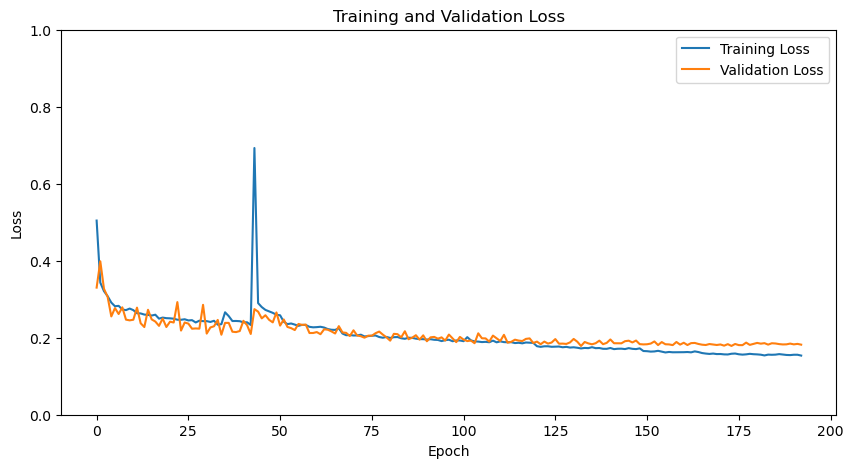

In [20]:
import matplotlib.pyplot as plt


# visualization
plt.figure(figsize=(10,5))
plt.plot(train_hist, label='Training Loss')
plt.plot(val_hist, label='Validation Loss')
plt.ylim([0,1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

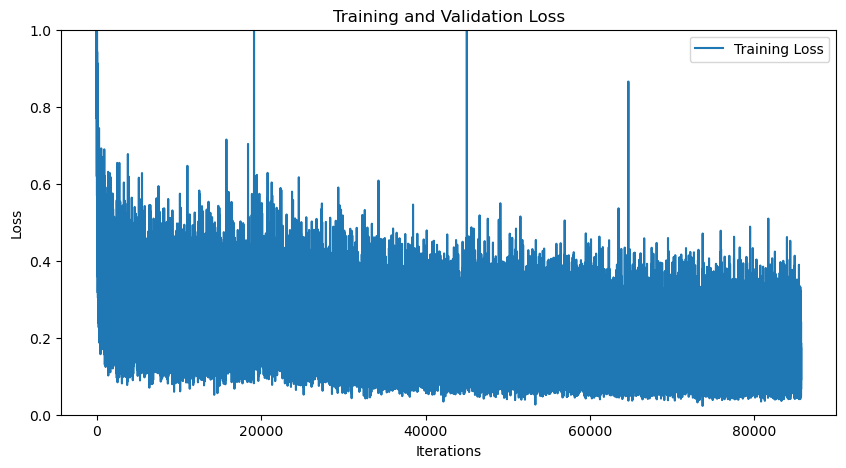

In [21]:
# visualization
plt.figure(figsize=(10,5))
plt.plot(train_hist_iter, label='Training Loss')
plt.ylim([0,1])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

The result has some randomness, so we should use the saved models.

In [ ]:
# torch.save(model.state_dict(), 'best_model_adam_11_11.pth')

#### 1.2 Hyperparameter Tuning (Grid Search)

The code below is really time-consuming. The Demo should just skip this part.

In [23]:
batch_size = 256
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True) 
validate_dataloader = DataLoader(dataset_validate, batch_size=batch_size, shuffle=True) 
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [22]:
param_grid = {
    'hidden_size':[256],
    'depth':[5,10,15],
    'dropout_p':[0.1,0.2,0.3],
    'lr':[5e-5,1e-4,5e-4],
    'activation_function':['LeakyReLU'],
    'weight_decay':[1e-7]
}



import itertools

keys = param_grid.keys()
values = param_grid.values()
param_combinations = [dict(zip(keys,v)) for v in itertools.product(*values)]

In [20]:
def train(model,train_dataloader,validate_dataloader,lr=1e-3,num_epochs=500,weight_decay=1e-6,params={}):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
    best_val_loss = np.inf
    patience = 60
    counter = 0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            # calculate the gradient
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataset_train)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in validate_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs).squeeze(-1)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)


        val_loss /= len(dataset_validate)
        scheduler.step(val_loss)

        # early stop
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break
        
        
    print(f'{params}:final train | val loss: {epoch_loss:.4f} | {val_loss:.4f}')
    return val_loss


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_params = None
batch_size = 256
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True) 
validate_dataloader = DataLoader(dataset_validate, batch_size=batch_size, shuffle=True) 
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [ ]:

import torch
best_val_loss_total = 200000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_params = None
batch_size = 256
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True) 
validate_dataloader = DataLoader(dataset_validate, batch_size=batch_size, shuffle=True) 
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
for params in param_combinations:
    model_adam_1 = NN_Model_1(hidden_size=params['hidden_size'],num_hidden_layers=params['depth'],activation_function=params['activation_function'],dropout_p=params['dropout_p']).to(device)
    val_loss_final = train(model_adam_1,train_dataloader,validate_dataloader,lr=params['lr'],num_epochs=200,weight_decay=params['weight_decay'],params=params)
    if val_loss_final < best_val_loss_total:
        best_train_loss = val_loss_final
        best_params = params
        torch.save(model_adam_1, 'best_model_adam_1.pth')

Early stopping triggered
{'hidden_size': 256, 'depth': 5, 'dropout_p': 0.1, 'lr': 5e-05, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1348 | 0.1997
Early stopping triggered
{'hidden_size': 256, 'depth': 5, 'dropout_p': 0.1, 'lr': 0.0001, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1235 | 0.1974
Early stopping triggered
{'hidden_size': 256, 'depth': 5, 'dropout_p': 0.1, 'lr': 0.0005, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1421 | 0.1797
Early stopping triggered
{'hidden_size': 256, 'depth': 5, 'dropout_p': 0.2, 'lr': 5e-05, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1874 | 0.2058
Early stopping triggered
{'hidden_size': 256, 'depth': 5, 'dropout_p': 0.2, 'lr': 0.0001, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1509 | 0.2041
Early stopping triggered
{'hidden_size': 256, 'depth': 5,

: 

#### **Grid Search Conclusions:**

Among these parameter combinations, these are the parameters that achieved relatively good results. They all showed a early sign of overfitting. In terms of overfitting, the third one has the best performance (lowest val loss). Then, the fourth one has the second best performance. The 4th model is special because it is the only model that didn't trigger early stop. If I gave it more epochs, or a slightly higher lr, its performance maybe even better.

1. {'hidden_size': 256, 'depth': 5, 'dropout_p': 0.1, 'lr': 5e-05, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1348 | 0.1997
2. {'hidden_size': 256, 'depth': 5, 'dropout_p': 0.1, 'lr': 0.0001, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1235 | 0.1974
3. **{'hidden_size': 256, 'depth': 5, 'dropout_p': 0.1, 'lr': 0.0005, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1421 | 0.1797**
4. **_{'hidden_size': 256, 'depth': 10, 'dropout_p': 0.1, 'lr': 0.0005, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1416 | 0.1851_**
5. {'hidden_size': 256, 'depth': 10, 'dropout_p': 0.1, 'lr': 0.0001, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1187 | 0.2004

There is also another model that didn't trigger early stopping.

{'hidden_size': 256, 'depth': 15, 'dropout_p': 0.1, 'lr': 0.0005, 'activation_function': 'LeakyReLU', 'weight_decay': 1e-07}:final train | val loss: 0.1646 | 0.1892

**It seems that 5e-4 is the best learning rate for Adam optimizer trained model, since 3 of the high performance models use `lr` = 5e-4**

On the other hand, the models training loss is still very high, so overfitting may not be the primary problem. These models may still lack the capability to learn enough paterns of the data.


Let's check the best model's r2 score

In [63]:
import matplotlib.pyplot as plt
def train_visualization(model,train_dataloader,validate_dataloader,lr=1e-3,num_epochs=500,weight_decay=1e-6):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
    best_val_loss = np.inf
    patience = 500
    counter = 0
    train_hist = []
    val_hist = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            # calculate the gradient
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataset_train)
        train_hist.append(epoch_loss)
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in validate_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs).squeeze(-1)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)


        val_loss /= len(dataset_validate)
        val_hist.append(val_loss)
        scheduler.step(val_loss)

        # early stop
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break
        
        if epoch % 10 == 0:
            print(f'{epoch} train | val loss: {epoch_loss:.4f} | {val_loss:.4f}')
    # visualization
    plt.figure(figsize=(10,5))
    plt.plot(train_hist, label='Training Loss')
    plt.plot(val_hist, label='Validation Loss')
    plt.ylim([0,1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    
    return val_loss


In [ ]:
model_adam_v1 = NN_Model_1(hidden_size=256,num_hidden_layers=10,activation_function='LeakyReLU',dropout_p=0.1).to(device)
val_loss_final = train_visualization(model_adam_v1,train_dataloader,validate_dataloader,lr=5e-4,num_epochs=200,weight_decay=1e-7)

In [ ]:

x_train = torch.tensor(X_train,dtype=torch.float32)
y_train = y_train.reshape(-1,1)
output_train = model_adam_v1(x_train)
y_pred = output_train.detach().numpy()
r2 = r2_score(y_train, y_pred)
print(f'The r2 score is: {r2}')

In [23]:
criterion = nn.MSELoss()

In [38]:
from sklearn.metrics import r2_score
val_loss = 0 
train_loss = 0
r2_train = 0
r2 = 0
with torch.no_grad():
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model_adam_v1(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        train_loss += loss.item() * inputs.size(0)
        r2_train += r2_score(targets.cpu(),outputs.cpu()) * inputs.size(0)

r2_train /= len(dataset_train)
train_loss /= len(dataset_train)
print(f'train_loss: {train_loss} | train_r2_score: {r2_train}')

with torch.no_grad():
    for inputs, targets in validate_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model_adam_v1(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)
        r2 += r2_score(targets.cpu(),outputs.cpu()) * inputs.size(0)
r2 /= len(dataset_validate)
val_loss /= len(dataset_validate)

print(f'val_loss: {val_loss} | val_r2_score: {r2}')

train_loss: 0.1314173728643463 | train_r2_score: 0.8662265928869651
val_loss: 0.19414851694168636 | val_r2_score: 0.8004153358866124


Based on this model, I tried to decrease / increase its anti-overfit parameter. 

- I found that 5e-4 may be too high, which caused the model to oscillate. The model reaches a very low val_loss at first, which causes a constant drop on the lr (because I used `torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=15)` and the model cannot reach the low val loss the model achieved at the first epochs after the oscillation.)
- After decreasing the anti-overfitting parameters, the model still can't obtain a validation loss lower than 0.18. When I set a really low learning rate and weight_decay, the model stars to overfit. Maybe I should try a deeper model?

0 train | val loss: 0.1653 | 0.2088
10 train | val loss: 0.1527 | 0.2004
20 train | val loss: 0.1531 | 0.2197
30 train | val loss: 0.1418 | 0.2172
40 train | val loss: 0.1353 | 0.2132
50 train | val loss: 0.1285 | 0.2147
60 train | val loss: 0.1234 | 0.2218
70 train | val loss: 0.1427 | 0.2465
80 train | val loss: 0.2117 | 0.2012
90 train | val loss: 0.1470 | 0.2093
100 train | val loss: 0.1225 | 0.2135
110 train | val loss: 0.1447 | 0.2282
120 train | val loss: 0.1044 | 0.2287
130 train | val loss: 0.1054 | 0.2056
140 train | val loss: 0.1267 | 0.2208
150 train | val loss: 0.0919 | 0.2121
160 train | val loss: 0.0905 | 0.2116
170 train | val loss: 0.1005 | 0.2217
180 train | val loss: 0.0811 | 0.2240
190 train | val loss: 0.0831 | 0.2137
200 train | val loss: 0.1077 | 0.2119
210 train | val loss: 0.0750 | 0.2211
220 train | val loss: 0.0744 | 0.2298
230 train | val loss: 0.0687 | 0.2288
240 train | val loss: 0.0719 | 0.2373
250 train | val loss: 0.0650 | 0.2371
260 train | val loss: 0

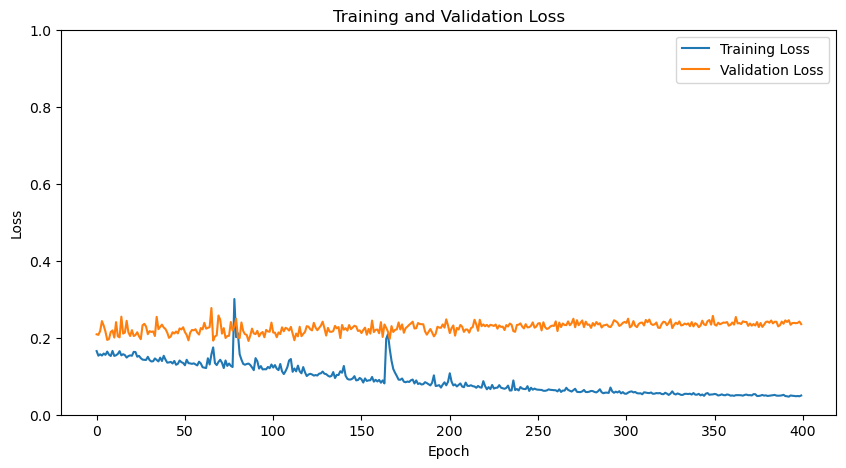

In [ ]:
# decrease the param (also changed the scheduler's factor as 0.9)
model_adam_v1_d = NN_Model_1(hidden_size=256,num_hidden_layers=15,activation_function='LeakyReLU',dropout_p=0.1).to(device)
val_loss_final = train_visualization(model_adam_v1,train_dataloader,validate_dataloader,lr=3e-4,num_epochs=400,weight_decay=1e-7)

**This one is overfitted**

I used this model for the ensemble NN. Adam optimizer is more robust agains gradient vanishing, so it can handle with deeper NNs without using other deep NN strategies.

model_adam_v1_d = NN_Model_1(hidden_size=256,num_hidden_layers=15,activation_function='LeakyReLU',dropout_p=0.1).to(device)

val_loss_final = train_visualization(model_adam_v1,train_dataloader,validate_dataloader,lr=3e-4,num_epochs=400,weight_decay=1e-7)



0 train | val loss: 0.7470 | 0.5725
10 train | val loss: 0.3381 | 0.2945
20 train | val loss: 0.3244 | 0.2865
30 train | val loss: 0.3340 | 0.2841
40 train | val loss: 0.3164 | 0.3045
50 train | val loss: 0.2763 | 0.2572
60 train | val loss: 0.3852 | 0.2981
70 train | val loss: 0.2885 | 0.2567
80 train | val loss: 0.2646 | 0.2517
90 train | val loss: 0.2520 | 0.2376
100 train | val loss: 0.2421 | 0.2319
110 train | val loss: 0.2369 | 0.2374
120 train | val loss: 80.2071 | 0.2692
130 train | val loss: 0.2933 | 0.2553
140 train | val loss: 0.2707 | 0.2525
150 train | val loss: 0.2589 | 0.2468
160 train | val loss: 0.2504 | 0.2509
170 train | val loss: 0.2432 | 0.2351
180 train | val loss: 0.2328 | 0.2297
190 train | val loss: 0.2298 | 0.2304
200 train | val loss: 0.2276 | 0.2274
210 train | val loss: 0.2250 | 0.2275
220 train | val loss: 0.2262 | 0.2274
230 train | val loss: 0.2267 | 0.2276
240 train | val loss: 0.2260 | 0.2268
250 train | val loss: 0.2260 | 0.2268
260 train | val loss: 

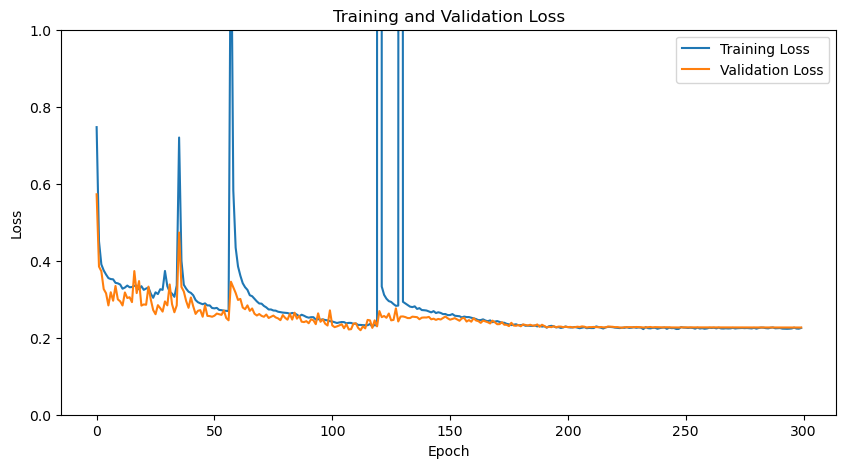

In [ ]:
# increase the anti-overfitting param with a deeper NN
model_adam_v1_i = NN_Model_1(hidden_size=256,num_hidden_layers=18,activation_function='LeakyReLU',dropout_p=0.3).to(device)
val_loss_final = train_visualization(model_adam_v1_i,train_dataloader,validate_dataloader,lr=5e-4,num_epochs=300,weight_decay=1e-6)

In [ ]:
from sklearn.metrics import r2_score
val_loss = 0 
train_loss = 0
r2_train = 0
r2 = 0
with torch.no_grad():
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model_adam_v1_d(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        train_loss += loss.item() * inputs.size(0)
        r2_train += r2_score(targets.cpu(),outputs.cpu()) * inputs.size(0)

r2_train /= len(dataset_train)
train_loss /= len(dataset_train)
print(f'train_loss: {train_loss} | train_r2_score: {r2_traain}')

with torch.no_grad():
    for inputs, targets in validate_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model_adam_v1_d(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)
        r2 += r2_score(targets.cpu(),outputs.cpu()) * inputs.size(0)
r2 /= len(dataset_validate)
val_loss /= len(dataset_validate)

print(f'val_loss: {val_loss} | val_r2_score: {r2}')

train_loss: 1.0010721789692782 | train_r2_score: -0.007828885646281137
val_loss: 0.9945766771063697 | val_r2_score: -0.007897325960088885


#### **2 SGD Optimizer**

let's try the SGD optimizer

##### 2.1 SGD Optimizer Training Function

In [20]:
import matplotlib.pyplot as plt
def train_visualization_SGD(model,train_dataloader,validate_dataloader,lr=1e-2,num_epochs=500,sche_patience = 20):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum= 0.95)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=sche_patience)
    best_val_loss = np.inf
    patience = 50
    counter = 0
    train_hist = []
    val_hist = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            # calculate the gradient
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataset_train)
        train_hist.append(epoch_loss)
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in validate_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs).squeeze(-1)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)


        val_loss /= len(dataset_validate)
        val_hist.append(val_loss)
        scheduler.step(val_loss)

        # early stop
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break
        
        if epoch % 10 == 0:
            print(f'{epoch} train | val loss: {epoch_loss:.4f} | {val_loss:.4f}')
    # visualization
    plt.figure(figsize=(10,5))
    plt.plot(train_hist, label='Training Loss')
    plt.plot(val_hist, label='Validation Loss')
    plt.ylim([0,1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    
    return val_loss


0 train | val loss: 1.0001 | 1.0227
10 train | val loss: 0.3000 | 0.3069
20 train | val loss: 0.2773 | 0.2693
30 train | val loss: 0.2304 | 0.2349
40 train | val loss: 0.2471 | 0.2329
50 train | val loss: 0.2227 | 0.2463
60 train | val loss: 0.2135 | 0.2211
70 train | val loss: 0.2303 | 0.2314
80 train | val loss: 0.2004 | 0.2185
90 train | val loss: 0.2001 | 0.1959
100 train | val loss: 0.2021 | 0.2154
110 train | val loss: 0.2175 | 0.3255
120 train | val loss: 0.2033 | 0.2037
130 train | val loss: 0.1950 | 0.2062
140 train | val loss: 0.1969 | 0.1990
150 train | val loss: 0.1862 | 0.1934
160 train | val loss: 0.1842 | 0.1985
170 train | val loss: 0.1721 | 0.1778
180 train | val loss: 0.1643 | 0.1800
190 train | val loss: 0.1563 | 0.2118
200 train | val loss: 0.1564 | 0.2081
210 train | val loss: 0.1579 | 0.1793
220 train | val loss: 0.1616 | 0.1844
230 train | val loss: 0.1432 | 0.1713
240 train | val loss: 0.1377 | 0.1723
250 train | val loss: 0.1353 | 0.2360
260 train | val loss: 0

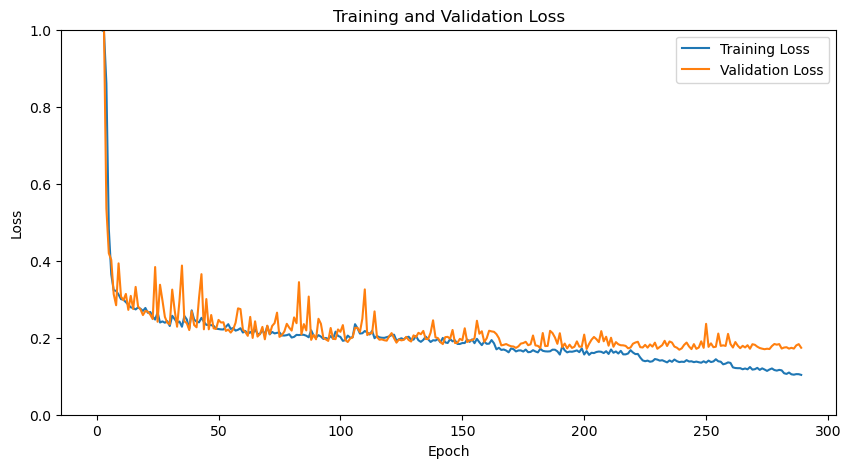

0.17393998639739078

In [25]:
# increase the anti-overfitting param with a deeper NN
model_SGD_1 = NN_Model_1(hidden_size=256,num_hidden_layers=10,activation_function='LeakyReLU',dropout_p=0).to(device)
train_visualization_SGD(model_SGD_1,train_dataloader,validate_dataloader,lr=1e-3,num_epochs=300,sche_patience = 20)

0 train | val loss: 0.2186 | 0.2587
10 train | val loss: 0.1930 | 0.1851
20 train | val loss: 0.1616 | 0.1791
30 train | val loss: 0.1742 | 0.1774
40 train | val loss: 0.1689 | 0.1963
50 train | val loss: 0.1443 | 0.1683
60 train | val loss: 0.1296 | 0.1787
70 train | val loss: 0.1265 | 0.1661
80 train | val loss: 0.1149 | 0.1663
90 train | val loss: 0.1077 | 0.1699
100 train | val loss: 0.1029 | 0.1693
110 train | val loss: 0.1012 | 0.1694
120 train | val loss: 0.0993 | 0.1686
Early stopping triggered


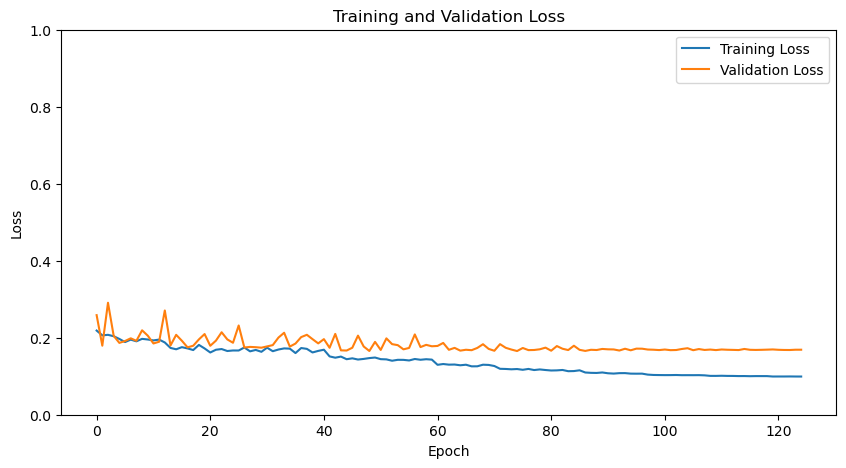

0.16885267793010908

In [27]:
model_SGD_2 = NN_Model_1(hidden_size=256,num_hidden_layers=10,activation_function='LeakyReLU',dropout_p=0.1).to(device)
train_visualization_SGD(model_SGD_1,train_dataloader,validate_dataloader,lr=8e-4,num_epochs=300,sche_patience=10)

##### 2.2 **BEST Model 1**

0 train | val loss: 1.0001 | 1.0228
10 train | val loss: 0.3163 | 0.3516
20 train | val loss: 0.2732 | 0.2628
30 train | val loss: 0.2829 | 0.2955
40 train | val loss: 0.2223 | 0.2504
50 train | val loss: 0.2200 | 0.2163
60 train | val loss: 0.2258 | 0.2231
70 train | val loss: 0.2209 | 0.1987
80 train | val loss: 0.1917 | 0.2346
90 train | val loss: 0.1921 | 0.2009
100 train | val loss: 0.1810 | 0.1968
110 train | val loss: 0.1813 | 0.2050
120 train | val loss: 0.1658 | 0.1735
130 train | val loss: 0.1621 | 0.1742
140 train | val loss: 0.1554 | 0.1690
150 train | val loss: 0.1426 | 0.1696
160 train | val loss: 0.1380 | 0.1650
170 train | val loss: 0.1322 | 0.1598
180 train | val loss: 0.1306 | 0.1662
190 train | val loss: 0.1250 | 0.1640
200 train | val loss: 0.1234 | 0.1631
210 train | val loss: 0.1216 | 0.1627
Early stopping triggered


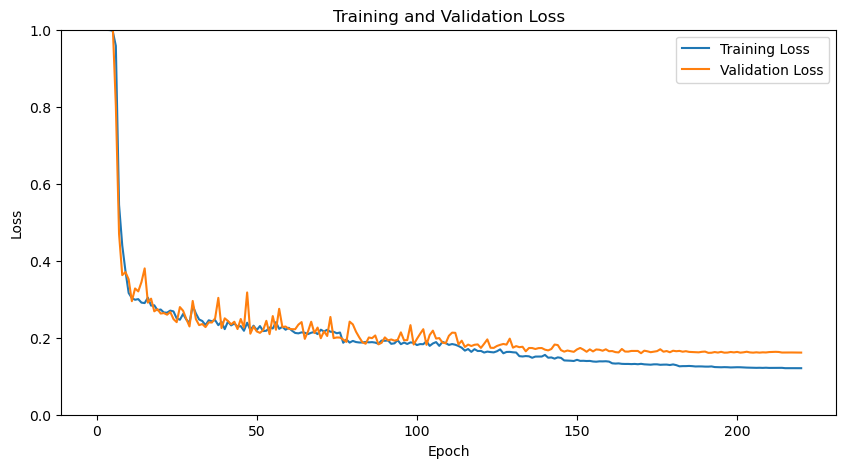

0.16138217764322044

In [ ]:
# decrease the patience
model_SGD_1 = NN_Model_1(hidden_size=256,num_hidden_layers=10,activation_function='LeakyReLU',dropout_p=0).to(device)
train_visualization_SGD(model_SGD_1,train_dataloader,validate_dataloader,lr=1e-3,num_epochs=300,sche_patience=10)

In [28]:
from sklearn.metrics import r2_score
val_loss = 0 
train_loss = 0
r2_train = 0
r2 = 0
criterion = nn.MSELoss()
with torch.no_grad():
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model_SGD_1(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        train_loss += loss.item() * inputs.size(0)
        r2_train += r2_score(targets.cpu(),outputs.cpu()) * inputs.size(0)

r2_train /= len(dataset_train)
train_loss /= len(dataset_train)
print(f'train_loss: {train_loss} | train_r2_score: {r2_train}')

with torch.no_grad():
    for inputs, targets in validate_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model_SGD_1(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)
        r2 += r2_score(targets.cpu(),outputs.cpu()) * inputs.size(0)
r2 /= len(dataset_validate)
val_loss /= len(dataset_validate)

print(f'val_loss: {val_loss} | val_r2_score: {r2}')

train_loss: 0.09847660447683423 | train_r2_score: 0.9001492864458505
val_loss: 0.16885267661359066 | val_r2_score: 0.8346185442309376


Based on these experiments, I can preliminarily conclude that, after hyperparameter tuning, **the Adam optimizer achieves a validation loss of approximately 0.18 on this dataset.** In contrast, the SGD optimizer delivers improved performance, reaching a validation loss of around 0.16 when using a subset of the optimal parameters identified through the Adam tuning process, such as network width and depth. **For this model, the validation R² score has reached 0.835, which is an acceptable level.**

In [ ]:
# SAVE THE MODEL
# torch.save(model_SGD_1.state_dict(), 'NN_model_1.pth')


In [33]:
# showing the structure of the model
print(model_SGD_1)

NN_Model_1(
  (sequential): Sequential(
    (0): Linear(in_features=80, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0, inplace=False)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Dropout(p=0, inplace=False)
    (15): Linear(in_features=256, out_features=256, bias=True)
    (16): LeakyReLU(negative_slope=0.01)
    (17): Dropout(p=0, inplace=False)
    (18): Linear(in_features=256, out_features=256, bias=True)
    (19): LeakyReLU(negative_slope=0.01)
    (20): Dropo

##### RUN THIS CODE TO READ THE BEST MODEL 1 BACK

The result has a little difference because the training process has some randomness.

In [48]:
NN_model_1_read = NN_Model_1(hidden_size=256,num_hidden_layers=10,activation_function='LeakyReLU',dropout_p=0).to(device)
state_dict = torch.load('NN_model_1.pth',weights_only=True)
NN_model_1_read.load_state_dict(state_dict)

<All keys matched successfully>

In [49]:
from sklearn.metrics import r2_score
val_loss = 0 
train_loss = 0
r2_train = 0
r2 = 0
NN_model_1_read.to(device)
criterion = nn.MSELoss()
with torch.no_grad():
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = NN_model_1_read(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        train_loss += loss.item() * inputs.size(0)
        r2_train += r2_score(targets.cpu(),outputs.cpu()) * inputs.size(0)

r2_train /= len(dataset_train)
train_loss /= len(dataset_train)
print(f'train_loss: {train_loss} | train_r2_score: {r2_train}')

with torch.no_grad():
    for inputs, targets in validate_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = NN_model_1_read(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)
        r2 += r2_score(targets.cpu(),outputs.cpu()) * inputs.size(0)
r2 /= len(dataset_validate)
val_loss /= len(dataset_validate)

print(f'val_loss: {val_loss} | val_r2_score: {r2}')

train_loss: 0.09847660402468732 | train_r2_score: 0.8998419864051368
val_loss: 0.16885267635610124 | val_r2_score: 0.8358807006510102


In [50]:

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = NN_model_1_read(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)
        r2 += r2_score(targets.cpu(),outputs.cpu()) * inputs.size(0)
r2 /= len(dataset_test)
val_loss /= len(dataset_test)

print(f'test_loss: {val_loss} | test_r2_score: {r2}')

test_loss: 0.16169414793517453 | test_r2_score: 0.8434658122667408


### **PyTorch Model 2**

**Ensembled NN**

I trained multiple NN models with different features and data. Then, these models's predictions' mean will be the ensembled NN's final prediction.

This model is overfitted, which could be used for ensemble models' parameters

In [ ]:
# model_adam_overfitted = NN_Model_1(hidden_size=256,num_hidden_layers=15,activation_function='LeakyReLU',dropout_p=0).to(device)
# val_loss_final = train_visualization(model_adam_overfitted,train_dataloader,validate_dataloader,lr=3e-4,num_epochs=400,weight_decay=1e-7)

In [29]:
batch_size = 256
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True) 
validate_dataloader = DataLoader(dataset_validate, batch_size=batch_size, shuffle=True) 

#### **1 Model training**

In [34]:
import os
os.environ['TORCHDYNAMO_DISABLE'] = '0'

In [21]:
import matplotlib.pyplot as plt

Model 1 training finished | Training Loss: 0.06578476985237865
Model 2 training finished | Training Loss: 0.05915572347107392
Model 3 training finished | Training Loss: 0.08350408886395946
Model 4 training finished | Training Loss: 0.06376708623168018
Model 5 training finished | Training Loss: 0.06696743480085188
Model 6 training finished | Training Loss: 0.04226019133635224
Model 7 training finished | Training Loss: 0.048789081430833645
Model 8 training finished | Training Loss: 0.055878175965666944
Model 9 training finished | Training Loss: 0.03992066217708048
Model 10 training finished | Training Loss: 0.08331157921230158
Model 11 training finished | Training Loss: 0.038545886734824134
Model 12 training finished | Training Loss: 0.07219638709657604
Model 13 training finished | Training Loss: 0.10364949989073152
Model 14 training finished | Training Loss: 0.0571840076505962
Model 15 training finished | Training Loss: 0.05375718111115308


IndexError: index 10 is out of bounds for axis 0 with size 10

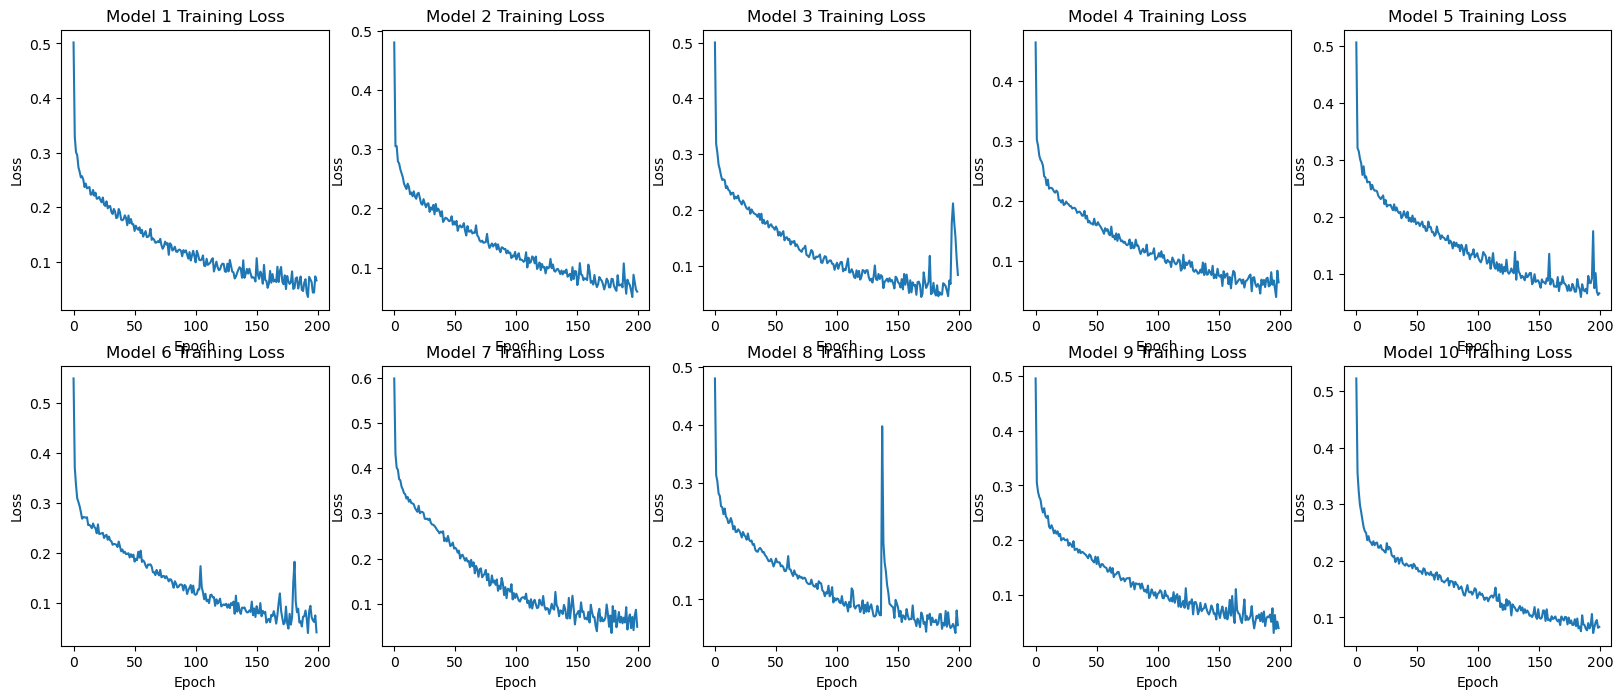

In [34]:
import torch._dynamo

n_estimators = 15 
num_epochs = 200
feature_subsample_size = int(X_train.shape[1] * 0.8)  
models = []
histories = []

test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True) 
validate_dataloader = DataLoader(dataset_validate, batch_size=batch_size, shuffle=True) 
criterion = nn.MSELoss()  # Choose the appropriate loss function

for idx in range(n_estimators):
    # Randomly select feature indices
    feature_indices = np.random.choice(X_train.shape[1], feature_subsample_size, replace=False)
    # Randomly select sample indices (optional)
    sample_indices = np.random.choice(len(X_train), size=int(len(X_train)*0.8), replace=True)
    
    X_subset = X_train[sample_indices][:, feature_indices]
    y_subset = y_train[sample_indices]
    
    dataset_partial = MyDataset(X_subset, y_subset)
    train_partial_dataloader = DataLoader(dataset_partial, batch_size=256, shuffle=True)
    
    # Define the model
    num_features_subset = X_subset.shape[1]  # Input size corresponds to the number of selected features
    model = NN_Model_1(input_size=num_features_subset, hidden_size=256, num_hidden_layers=15,
                       activation_function='LeakyReLU', dropout_p=0).to(device)
    criterion = nn.MSELoss()  # Choose appropriate loss function according to task
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-7)
    
    # Train the model
    train_hist = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_partial_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            # Zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataset_partial)
        train_hist.append(epoch_loss)

    print(f'Model {idx+1} training finished | Training Loss: {epoch_loss}')
    
    # Save the model, corresponding feature indices, and training history
    models.append((model, feature_indices))
    histories.append(train_hist)

# Plot training loss curves
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, history in enumerate(histories):
    axes[i].plot(history)
    axes[i].set_title(f'Model {i+1} Training Loss')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')

plt.tight_layout()
plt.show()

# Ensemble prediction on validation data
ensemble_predictions = []
with torch.no_grad():
    for model, feature_indices in models:
        model.eval()
        val_predictions = []
        for inputs, targets in validate_dataloader:
            # Select the same features used in training
            inputs = inputs[:, feature_indices].to(device)
            outputs = model(inputs).squeeze(-1)
            val_predictions.append(outputs.cpu().numpy())
        val_predictions = np.concatenate(val_predictions)
        ensemble_predictions.append(val_predictions)

# Average the predictions from all models
ensemble_predictions = np.mean(ensemble_predictions, axis=0)

# Get the true targets from validation data
val_targets = []
for _, targets in validate_dataloader:
    val_targets.append(targets.numpy())
val_targets = np.concatenate(val_targets)

# Compute validation loss
val_loss = np.mean((ensemble_predictions - val_targets) ** 2)
print(f'Ensemble Validation Loss: {val_loss}')


The ensemble NN's performance is great.

In [32]:
models_1 = models

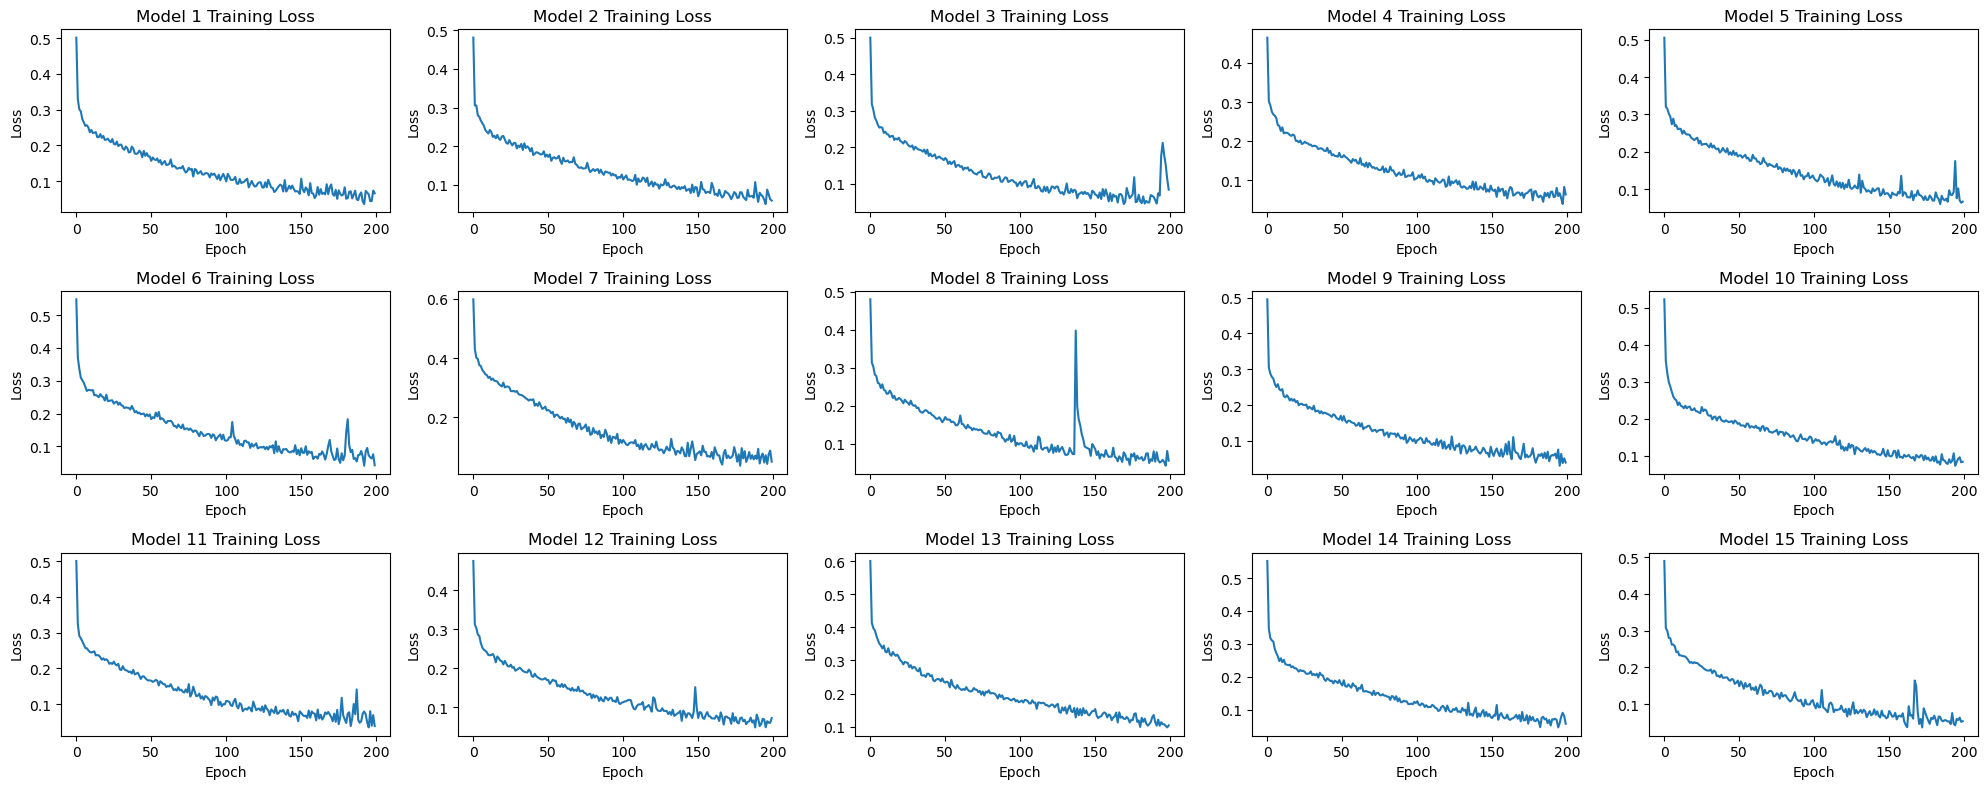

In [40]:

# Plot training loss curves
fig, axes = plt.subplots(3, 5, figsize=(20, 8))
axes = axes.flatten()

for i, history in enumerate(histories):
    axes[i].plot(history)
    axes[i].set_title(f'Model {i+1} Training Loss')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')

plt.tight_layout()
plt.show()



#### **2 Saving Model 2**

In [45]:
import os

# Create a directory to save models
os.makedirs('saved_models', exist_ok=True)

for idx, (model, feature_indices) in enumerate(models):
    # Save the model's state_dict
    model_path = f'saved_models/model_{idx+1}_state_dict.pth'
    torch.save(model.state_dict(), model_path)
    
    # Save the feature indices
    feature_indices_path = f'saved_models/model_{idx+1}_feature_indices.npy'
    np.save(feature_indices_path, feature_indices)
    
    print(f'Model {idx+1} and feature indices saved.')


Model 1 and feature indices saved.
Model 2 and feature indices saved.
Model 3 and feature indices saved.
Model 4 and feature indices saved.
Model 5 and feature indices saved.
Model 6 and feature indices saved.
Model 7 and feature indices saved.
Model 8 and feature indices saved.
Model 9 and feature indices saved.
Model 10 and feature indices saved.
Model 11 and feature indices saved.
Model 12 and feature indices saved.
Model 13 and feature indices saved.
Model 14 and feature indices saved.
Model 15 and feature indices saved.


#### **3 Read the Ensemble NN model Back**

In [46]:
# Load models and feature indices
loaded_models = []
n_estimators = 15  
feature_subsample_size = int(X_train.shape[1] * 0.8)  
for idx in range(n_estimators):
    # Load the model's state_dict
    model_path = f'saved_models/model_{idx+1}_state_dict.pth'
    state_dict = torch.load(model_path,weights_only=True)
    
    # Create a new model instance
    model = NN_Model_1(input_size=64, hidden_size=256, num_hidden_layers=15,
                       activation_function='LeakyReLU', dropout_p=0).to(device)
    model.load_state_dict(state_dict)
    model.eval()
    
    # Load the feature indices
    feature_indices_path = f'saved_models/model_{idx+1}_feature_indices.npy'
    feature_indices = np.load(feature_indices_path)
    
    # Append to the list
    loaded_models.append((model, feature_indices))
    
    print(f'Model {idx+1} and feature indices loaded.')


Model 1 and feature indices loaded.
Model 2 and feature indices loaded.
Model 3 and feature indices loaded.
Model 4 and feature indices loaded.
Model 5 and feature indices loaded.
Model 6 and feature indices loaded.
Model 7 and feature indices loaded.
Model 8 and feature indices loaded.
Model 9 and feature indices loaded.
Model 10 and feature indices loaded.
Model 11 and feature indices loaded.
Model 12 and feature indices loaded.
Model 13 and feature indices loaded.
Model 14 and feature indices loaded.
Model 15 and feature indices loaded.


#### **4 Prediction Function for Ensemble NN**

In [26]:
from sklearn.metrics import mean_squared_error, r2_score

def ensemble_predict(models, dataloader, device='cpu'):
    """
    Make predictions using an ensemble of neural network models.

    Parameters:
    - models: list of tuples (model, feature_indices)
    - dataloader: PyTorch DataLoader providing input data
    - device: 'cpu' or 'cuda'

    Returns:
    - ensemble_predictions: numpy array of ensemble predictions
    - targets: numpy array of true target values
    """
    import numpy as np
    ensemble_predictions = []
    targets = []
    
    # Initialize a list to hold predictions from each model
    model_predictions_list = [[] for _ in models]
    
    with torch.no_grad():
        for batch_idx, (inputs, batch_targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            batch_predictions = []
            
            for model_idx, (model, feature_indices) in enumerate(models):
                model.eval()
                inputs_subset = inputs[:, feature_indices]
                outputs = model(inputs_subset).squeeze(-1)
                model_predictions_list[model_idx].append(outputs.cpu().numpy())
            
            # Collect targets once
            if batch_idx == 0:
                targets = batch_targets.numpy()
            else:
                targets = np.concatenate((targets, batch_targets.numpy()))
    
    # Concatenate predictions from each model and average
    for model_idx in range(len(models)):
        model_preds = np.concatenate(model_predictions_list[model_idx])
        ensemble_predictions.append(model_preds)
    
    # Compute the mean prediction across all models
    ensemble_predictions = np.mean(ensemble_predictions, axis=0)
    
    return ensemble_predictions, targets


    

# 使用函数进行预测
ensemble_preds, true_targets = ensemble_predict(loaded_models, test_dataloader, device=device)

# 计算 MSE 和 R² 分数
mse = mean_squared_error(true_targets, ensemble_preds)
r2 = r2_score(true_targets, ensemble_preds)
print(f'Ensemble MSE: {mse:.4f}')
print(f'Ensemble R² Score: {r2:.4f}')


Ensemble MSE: 0.0766
Ensemble R² Score: 0.9253


In [47]:
ensemble_preds, true_targets = ensemble_predict(loaded_models, train_dataloader, device=device)

# 计算 MSE 和 R² 分数
mse = mean_squared_error(true_targets, ensemble_preds)
r2 = r2_score(true_targets, ensemble_preds)
print(f'Training Ensemble MSE: {mse:.4f}')
print(f'Training Ensemble R² Score: {r2:.4f}')

ensemble_preds, true_targets = ensemble_predict(loaded_models, validate_dataloader, device=device)

# 计算 MSE 和 R² 分数
mse = mean_squared_error(true_targets, ensemble_preds)
r2 = r2_score(true_targets, ensemble_preds)
print(f'Validation Ensemble MSE: {mse:.4f}')
print(f'Validation Ensemble R² Score: {r2:.4f}')

ensemble_preds, true_targets = ensemble_predict(loaded_models, test_dataloader, device=device)

# 计算 MSE 和 R² 分数
mse = mean_squared_error(true_targets, ensemble_preds)
r2 = r2_score(true_targets, ensemble_preds)
print(f'Test Ensemble MSE: {mse:.4f}')
print(f'Test Ensemble R² Score: {r2:.4f}')

Training Ensemble MSE: 0.0724
Training Ensemble R² Score: 0.9276
Validation Ensemble MSE: 0.1787
Validation Ensemble R² Score: 0.8253
Test Ensemble MSE: 0.1662
Test Ensemble R² Score: 0.8381


In [38]:
ensemble_preds, true_targets = ensemble_predict(models, train_dataloader, device=device)

# 计算 MSE 和 R² 分数
mse = mean_squared_error(true_targets, ensemble_preds)
r2 = r2_score(true_targets, ensemble_preds)
print(f'Training Ensemble MSE: {mse:.4f}')
print(f'Training Ensemble R² Score: {r2:.4f}')

ensemble_preds, true_targets = ensemble_predict(models, validate_dataloader, device=device)

# 计算 MSE 和 R² 分数
mse = mean_squared_error(true_targets, ensemble_preds)
r2 = r2_score(true_targets, ensemble_preds)
print(f'Validation Ensemble MSE: {mse:.4f}')
print(f'Validation Ensemble R² Score: {r2:.4f}')

ensemble_preds, true_targets = ensemble_predict(models, test_dataloader, device=device)

# 计算 MSE 和 R² 分数
mse = mean_squared_error(true_targets, ensemble_preds)
r2 = r2_score(true_targets, ensemble_preds)
print(f'Test Ensemble MSE: {mse:.4f}')
print(f'Test Ensemble R² Score: {r2:.4f}')

Training Ensemble MSE: 0.0724
Training Ensemble R² Score: 0.9276
Validation Ensemble MSE: 0.1787
Validation Ensemble R² Score: 0.8253
Test Ensemble MSE: 0.1662
Test Ensemble R² Score: 0.8381
